In [1]:
%load prepareStats.py

C:\Users\micha\AppData\Local\Temp\ipykernel_18308\839611307.py:41: FutureWarning: Passing 'suffixes' which cause duplicate columns {'url_x'} in the result is deprecated and will raise a MergeError in a future version.
  results = results.merge(constructors, on="constructorId", how="right")


## Drivers with the most race-ending crashes and the highest race-ending crash ratios 

In [2]:
crashDNF = results[(results.status.isin(crashes))]

In [3]:
driversMostCrashes = crashDNF.groupby("fullname").size()

In [4]:
driversMostCrashes.nlargest(10)

fullname
Andrea de Cesaris       37
Riccardo Patrese        36
David Coulthard         32
Rubens Barrichello      32
Giancarlo Fisichella    30
Jean Alesi              30
Johnny Herbert          30
Michael Schumacher      30
Ukyo Katayama           30
Jarno Trulli            29
dtype: int64

In [5]:
carnageExperts = results[(results.status.isin(crashes)) & (results.entries >= 10)].groupby(["surname", "forename"]).size() / results.groupby(["surname", "forename"]).size()

In [6]:
carnageExperts.nlargest(10)

surname    forename
Andretti   Michael     0.461538
Brise      Tony        0.400000
Inoue      Taki        0.333333
Tuero      Esteban     0.312500
Katayama   Ukyo        0.309278
Chiesa     Andrea      0.300000
Lavaggi    Giovanni    0.300000
Scheckter  Ian         0.300000
Blundell   Mark        0.285714
Pantano    Giorgio     0.285714
dtype: float64

## The most challenging circuits in the Lewis Hamilton era

In [30]:
pd.options.display.float_format = '{:.2%}'.format

In [31]:
resultsLHera = results[results["year"] > 2006]

circuitsLHEResults = resultsLHera.groupby(["location"]).size()

In [32]:
crashDNFLHera = crashDNF[crashDNF["year"] > 2006]

circuitsDNFLHera = crashDNFLHera.groupby(["location"]).size()

In [33]:
circuitsLHeraGPs = resultsLHera.groupby(["location"])["year_round"].nunique()

In [34]:
mergedCircuitStats = pd.concat([circuitsLHeraGPs, circuitsLHEResults, circuitsDNFLHera], axis=1, keys=["circuitsLHeraGPs", "circuitsLHEResults", "circuitsDNFLHera"])

In [35]:
mergedCircuitStats["ratio"] =  mergedCircuitStats["circuitsDNFLHera"] / mergedCircuitStats["circuitsLHEResults"]

In [36]:
mergedCircuitStats["ratio"].sort_values(ascending=False).head(5)

location
Mugello          30.00%
Indianapolis     18.18%
Jeddah           17.50%
Yeongam County   15.96%
Monte-Carlo      14.67%
Name: ratio, dtype: float64

In [37]:
frequentCircuitStats = mergedCircuitStats[mergedCircuitStats["circuitsLHeraGPs"] > 2]

In [38]:
frequentCircuitStats["ratio"].sort_values(ascending=False).nlargest(5)

location
Yeongam County   15.96%
Monte-Carlo      14.67%
Melbourne        11.67%
Marina Bay       11.24%
Baku             10.78%
Name: ratio, dtype: float64

## On what lap do the crashes occur?

Todo: calculate a race progress percentage and work with it rather than with a lap count.

In [16]:
crashDNFLHera = crashDNF[crashDNF["year"] > 2001]

In [17]:
whatLap = crashDNFLHera[["laps"]]

In [18]:
howManyBins = crashDNFLHera[["laps"]].max()

array([[<AxesSubplot:title={'center':'laps'}>]], dtype=object)

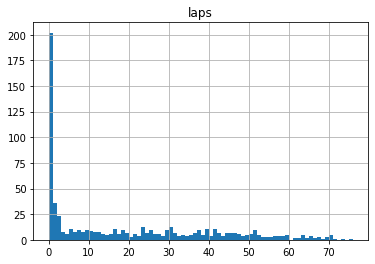

In [19]:
whatLap.hist(bins = 76)